# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

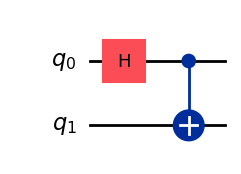

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([1.        , 0.00976562, 0.00976562, 1.        , 0.01367188,
       0.01367188]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0095319, 'sample_measure_time': 0.0021672, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999046325683594, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0095319, 'sample_measure_time': 0.0021672, '

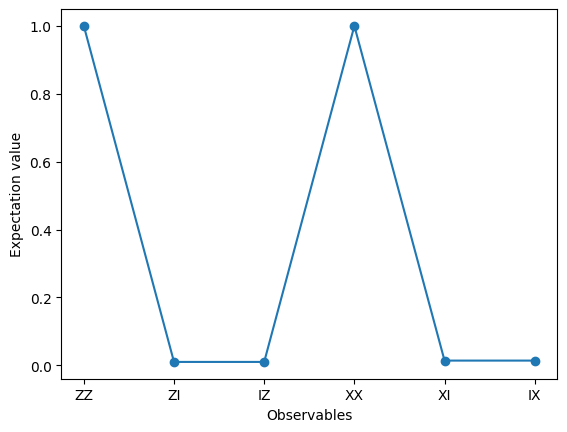

In [6]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 4  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 2.0  # Deductible amount
coins = 0.4
c_param = 0.015 # <-- keep in sync with apply_excess_rotations

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
mid_step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + mid_step / 2,
    domain_max - mid_step / 2,
    N
)
step = mid_x_vals[1] - mid_x_vals[0]
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

In [8]:
print(f"grid: {mid_x_vals}")
grid_space = mid_x_vals[1] - mid_x_vals[0]
print(f"grid space: {grid_space}")
print(f"step: {step}")

grid: [0.33333333 0.95555556 1.57777778 2.2        2.82222222 3.44444444
 4.06666667 4.68888889 5.31111111 5.93333333 6.55555556 7.17777778
 7.8        8.42222222 9.04444444 9.66666667]
grid space: 0.6222222222222222
step: 0.6222222222222222


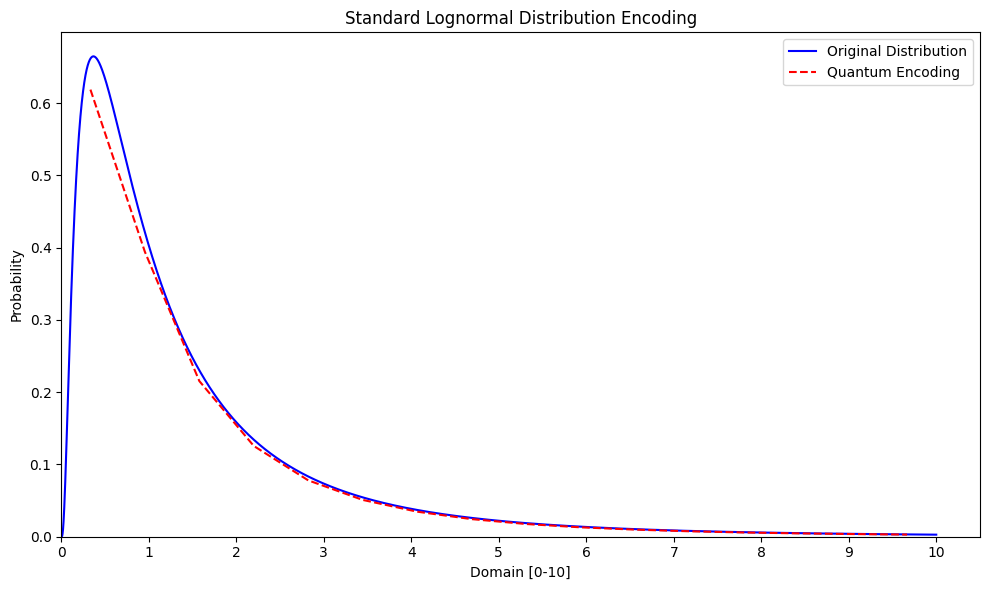

In [9]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

In [10]:
# num_qubits_list = range(2, 8)
# N_list = [2**n for n in num_qubits_list]
# step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# # Take the midpoint integral approximation to work on small number of qubits
# mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
# probabilities_list = []
# for i, N in enumerate(N_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
#     probabilities /= probabilities.sum()
#     probabilities_list.append(probabilities)

# # Add Color
# cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# # Plot the original distribution vs quantum encoded distribution
# plt.figure(figsize=(10, 6))
# plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
# for i, N in enumerate(num_qubits_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = probabilities_list[i]
#     alpha = 1/(i/2 + 1)
#     plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
# plt.xlabel('Domain [0-10]')
# plt.ylabel('Probability')
# plt.xticks(np.arange(domain_min, domain_max + 1, 1))
# plt.title('Loss Distribution Degeneration')
# plt.legend()
# plt.tight_layout()
# plt.axis([0, None, 0, None])
# plt.show()

# # # Display the first few amplitudes
# # print("First 10 amplitudes:")
# # for i in range(10):
# #     print(
# #         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Diagnostic

## Implement Quantum Subtraction

In [11]:
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 3
binary threshold = 0011


### Endianness Diagnostic

In [12]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# 1. Build the state-prep circuit
loss_q   = QuantumRegister(num_qubits, "x")
qc_prep  = QuantumCircuit(loss_q)
qc_prep.append(StatePreparation(np.sqrt(probabilities)), loss_q)

# 2. Prepare registers for the comparator test
flag_q   = QuantumRegister(1,             "flag")
wcmp_q   = QuantumRegister(num_qubits-1,  "wcmp")
qc = qc_prep.copy()
qc.add_register(flag_q, wcmp_q)

# 3. Define the comparator gate
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# 4. Try both orderings
print("classical tail =", probabilities[threshold_idx:].sum())
for name, order in [("MSB→LSB",       list(loss_q)),
                    ("LSB→MSB (rev)", list(reversed(loss_q)))]:
    qc_test = qc.copy()
    qc_test.append(cmp_gate,
                    order         # try one of the two
                    + [flag_q[0]]  # then the flag
                    + list(wcmp_q))# then the workspace
    p_flag = Statevector.from_instruction(qc_test) \
            .probabilities_dict(qargs=[qc_test.qubits.index(flag_q[0])]) \
            .get('1',0)
    print(f"{name:>12} ordering →  P(flag=1) = {p_flag:.6f}")


classical tail = 0.23567336384650622
     MSB→LSB ordering →  P(flag=1) = 0.235673
LSB→MSB (rev) ordering →  P(flag=1) = 0.555516


In [13]:
from scipy.stats import lognorm
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate, RYGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

print("x_vals head:", mid_x_vals[:5])
print("x_vals tail:", mid_x_vals[-5:])
print("deductible d =", deductible)

def make_subtractor(loss_reg, constant) -> QuantumCircuit:
    """
    Quantum circuit that maps |x> -> |x - constant mod 2^n>
    on 'loss_reg'.

    Parameters
    ----------
    loss_reg    : QuantumRegister (or list of Qubits)
        Register that stores an unsigned integer.
    constant    : int
        Positive integer < 2^n to subtract.
    """
    n  = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"-{constant}")

    # 1) Reverse into little-endian
    rev = loss_reg[::-1]

    # 2) QFT (decomposed → gate)
    qft_circ = QFT(num_qubits=n, do_swaps=False)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, rev)
    # 
    # 3) Phase shift: subtract constant via phases
    for k, qb in enumerate(rev):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.rz(angle, qb)

    # 4) Inverse QFT (decomposed → gate)
    inv_circ   = QFT(num_qubits=n, do_swaps=False).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    inv_gate = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, rev)

    # 5) Reverse back to MSB-first
    for i in range(n // 2):
        qc.swap(loss_reg[i], loss_reg[n - 1 - i])

    return qc

print("⦿ classical P(X≥ded) =", probabilities[threshold_idx:].sum())

# --- 1) State-prep --------------------------------------------------------
x_q = QuantumRegister(num_qubits, "x")
qc  = QuantumCircuit(x_q)
qc.append(StatePreparation(np.sqrt(probabilities)), x_q)

# --- 2) Comparator → flag  (MSB→LSB) --------------------------------------
flag_q = QuantumRegister(1, "flag")
wcmp_q = QuantumRegister(num_qubits-1, "wcmp")
qc.add_register(flag_q, wcmp_q)

cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)
# MSB→LSB: x_q[0] is MSB, x_q[-1] is LSB
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# sanity-check the comparator alone
sv     = Statevector.from_instruction(qc)
f_idx  = qc.qubits.index(flag_q[0])
p_flag = sv.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ quantum  P(flag=1) =", p_flag)

# --- 3) QFT-subtractor (controlled on the same flag) ----------------------
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor")
csub_gate = sub_gate.control(1)
qc.append(csub_gate, [flag_q[0]] + list(x_q))

payout_aux = QuantumRegister(1, "payout_aux")
qc.add_register(payout_aux)

# And encode the excess into the ancilla:
for i, qb in enumerate(list(x_q)[::-1]):        # i=0 is LSB, i=3 is MSB
    angle = -2 * np.pi * c_param * (2**i)           # weights = 1, 2, 4, 8 for a 4-qubit reg
    # Build a 2-control RY(angle):
    cry2 = RYGate(angle).control(2)         
    # Controls [flag, this bit], target payout_aux[0]:
    qc.append(cry2, [flag_q[0], qb, payout_aux[0]])
    
    # And the matching phase‐correction RZ(angle):
    # A single control on flag is enough, since the bit-control only affects the RY path.
    crz2 = RZGate(angle).control(2)
    qc.append(crz2, [flag_q[0], qb, payout_aux[0]])


aux_flag = QuantumRegister(1, "aux_flag")
qc.add_register(aux_flag)
qc.cx(flag_q[0], aux_flag[0])

# uncompute the ancillas of the first comparator
qc.append(cmp_gate,
        list(x_q)       # data bits
        + [aux_flag[0]]  # ← use aux_flag
        + list(wcmp_q))

# Final sanity-check
sv2    = Statevector.from_instruction(qc)
p_flag2 = sv2.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ after QFT-sub, P(flag=1) =", p_flag2)

print("Payout ancilla index should be:", qc.qubits.index(payout_aux[0]))

# --- 4) (optional) controlled-rotations + measurement --------------------
# from here you can call add_measure_qubit_and_bias(qc) and
# apply_excess_rotations(qc, x_q, flag_q[0], meas_q[0], step, c_param)
# then measure and back-out the expected payment.  

# Your P(flag=1) should now be ~0.5062, and your final E[payment] ~0.34.

x_vals head: [0.33333333 0.95555556 1.57777778 2.2        2.82222222]
x_vals tail: [7.17777778 7.8        8.42222222 9.04444444 9.66666667]
deductible d = 2.0
⦿ classical P(X≥ded) = 0.23567336384650622
⦿ quantum  P(flag=1) = 0.23567336384650692
⦿ after QFT-sub, P(flag=1) = 0.23567336384650725
Payout ancilla index should be: 8


In [14]:
for inst in qc.data:
    if inst.operation.name in ("cry","rz"):
        print(inst.operation.name, inst.operation.params[0], "→", [qc.qubits.index(q) for q in inst.qubits])

In [15]:
def smoke_test_pure_subtractor(n, threshold_idx):
    for x in range(2**n):
        reg = QuantumRegister(n, "x")
        qc  = QuantumCircuit(reg)
        # prepare |x>
        for j in range(n):
            if (x >> (n-1-j)) & 1:
                qc.x(reg[j])
        qc.append(make_subtractor(reg, threshold_idx), reg)
        # check on data register only (ignore ancilla)
        sv  = Statevector.from_instruction(qc)
        data_qargs = [qc.qubits.index(qb) for qb in reg]
        probs = sv.probabilities_dict(qargs=data_qargs)
        out = max(probs, key=probs.get)
        got = int(out, 2)
        want = (x - threshold_idx) % (2**n)
        if got != want:
            print(f"FAIL: x={x:02d} → got {got:02d} ({got:04b}₂), expected {want:02d} ({want:04b}₂)")
            return
    print("✅ subtractor matches classical arithmetic for all inputs")


smoke_test_pure_subtractor(num_qubits, threshold_idx)

✅ subtractor matches classical arithmetic for all inputs


In [16]:
def smoke_test_controlled_subtractor(n, threshold_idx):
    for x in range(2**n):
        # ── build a fresh 5-qubit circuit ─────────────────────────────────
        flag = QuantumRegister(1,  "flag")
        reg = QuantumRegister(n,  "x")
        qc_c = QuantumCircuit(flag, reg)

        # 1) set flag = |1⟩ so the controlled-subtractor actually runs
        qc_c.x(flag[0])

        # 2) prepare |x⟩ on the data register
        for j in range(n):
            if (x >> (n-1-j)) & 1:
                qc_c.x(reg[j])

        # 3) append the 5-qubit controlled-subtractor
        sub_gate = make_subtractor(reg, threshold_idx).to_gate()
        csub_gate = sub_gate.control(1)
        qc_c.append(csub_gate, [flag[0]] + list(reg))

        # 4) simulate and read out just the data bits
        sv = Statevector.from_instruction(qc_c)
        data_qargs = [qc_c.qubits.index(qb) for qb in reg]
        probs = sv.probabilities_dict(qargs=data_qargs)
        out = max(probs, key=probs.get)
        got = int(out, 2)
        want = (x - threshold_idx) % (2**n)

        if got != want:
            print(
                f"FAIL: x={x:02d} → got {got:02d} ({got:0{n}b}), expected {want:02d} ({want:0{n}b})")
            return

    print("✅ controlled-subtractor matches classical arithmetic for all inputs")


smoke_test_controlled_subtractor(num_qubits, threshold_idx)

✅ controlled-subtractor matches classical arithmetic for all inputs


In [17]:
def check_subtractor(n, const, big_endian=False):
    # 1) Create just the data register and build the circuit
    reg = QuantumRegister(n, "x")
    qc = QuantumCircuit(reg)

    # 2) Initialize to all 1’s: |111…1>
    qc.x(reg)

    # 3) Decide ordering for make_subtractor
    if big_endian:
        qs = reg                 # MSB→LSB
    else:
        qs = reg[::-1]           # LSB→MSB

    # 4) Append the pure 4-qubit subtractor on exactly those n qubits
    qc.append(make_subtractor(qs, const), list(qs))

    # 5) Grab the output state and show only amplitudes >1%
    bits = Statevector.from_instruction(qc).probabilities_dict()
    filtered = {k: v for k, v in bits.items() if v > 0.01}

    # 6) Print results
    start = 2**n - 1
    want = (start - const) % (2**n)
    print(f"Starting state: |{'1'*n}⟩ (decimal: {start})")
    print(f"Subtracting: {const}")
    print(f"Expected result: |{want:0{n}b}⟩ (decimal: {want})")
    print("Actual result (states with probability > 0.01):")
    for state, prob in filtered.items():
        print(f"  |{state}⟩: {prob:.6f} (decimal: {int(state, 2)})")
    print("─" * 30)


# Run your checks:
check_subtractor(num_qubits, 1, big_endian=True)
check_subtractor(num_qubits, 2, big_endian=True)
check_subtractor(num_qubits, 3, big_endian=True)

Starting state: |1111⟩ (decimal: 15)
Subtracting: 1
Expected result: |1110⟩ (decimal: 14)
Actual result (states with probability > 0.01):
  |1110⟩: 1.000000 (decimal: 14)
──────────────────────────────
Starting state: |1111⟩ (decimal: 15)
Subtracting: 2
Expected result: |1101⟩ (decimal: 13)
Actual result (states with probability > 0.01):
  |1101⟩: 1.000000 (decimal: 13)
──────────────────────────────
Starting state: |1111⟩ (decimal: 15)
Subtracting: 3
Expected result: |1100⟩ (decimal: 12)
Actual result (states with probability > 0.01):
  |1100⟩: 1.000000 (decimal: 12)
──────────────────────────────


In [18]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import StatePreparation
import numpy as np

# --- 1) Real circuit under test (flag + loss only) ---
flag = QuantumRegister(1,       "flag")
loss = QuantumRegister(num_qubits, "x")
qc_subtest = QuantumCircuit(flag, loss)

# Load the distribution onto loss (MSB→LSB)
qc_subtest.append(StatePreparation(np.sqrt(probabilities)), loss[::-1])
qc_subtest.x(flag[0])

# Build and append the 5-qubit controlled-subtractor
sub_gate = make_subtractor(loss, threshold_idx).to_gate()
csub_gate = sub_gate.control(1)
# **exactly** 1 flag + n loss qubits
qc_subtest.append(csub_gate, [flag[0]] + list(loss))

# Simulate
sv2 = Statevector.from_instruction(qc_subtest)
sv2_probs = np.abs(sv2.data)**2

# --- 2) Operator-based expected state (flag + loss only) ---
qc_init = QuantumCircuit(flag, loss)
qc_init.append(StatePreparation(np.sqrt(probabilities)), loss[::-1])
qc_init.x(flag[0])
psi0 = Statevector.from_instruction(qc_init)

Ucsub = Operator(csub_gate)          # shape 2^(n+1)×2^(n+1)
psi_exp = Ucsub.data @ psi0.data
exp_probs = np.abs(psi_exp)**2

# --- 3) Compare ---
print("subtract correct:", np.allclose(sv2_probs, exp_probs, atol=1e-8))
for idx, (p_act, p_exp) in enumerate(zip(sv2_probs, exp_probs)):
    if not np.isclose(p_act, p_exp, atol=1e-8):
        bitstr = format(idx, f'0{num_qubits+1}b')
        print(
            f"mismatch at index {bitstr}: actual {p_act:.6f} vs expected {p_exp:.6f}")

subtract correct: True


In [19]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import numpy as np

def test_subtractor():
    n   = num_qubits
    thr = threshold_idx

    for j in range(2**n):
        # 1) fresh flag + data registers
        flag_q = QuantumRegister(1, "flag")
        x_q    = QuantumRegister(n, "x")
        qc     = QuantumCircuit(flag_q, x_q)

        # 2) set flag = |1>
        qc.x(flag_q[0])

        # 3) prepare |j> on the data register
        for i, bit in enumerate(format(j, f"0{n}b")):
            if bit == '1':
                qc.x(x_q[i])

        # 4) append the 5-qubit controlled-subtractor
        sub_gate  = make_subtractor(x_q, thr).to_gate(label="qft_subtractor")
        csub_gate = sub_gate.control(1)
        qc.append(csub_gate, [flag_q[0]] + list(x_q))

        # 5) simulate and read out just the data bits
        sv = Statevector.from_instruction(qc)
        data_idxs = [qc.qubits.index(q) for q in x_q]
        probs     = sv.probabilities_dict(qargs=data_idxs)

        # pick the most likely outcome
        got_str = max(probs, key=probs.get)
        got     = int(got_str, 2)

        want = (j - thr) % (2**n)
        if got != want:
            print(f"ERROR: j={j}, expected={want} ({want:0{n}b}), got={got} ({got:0{n}b})")
            return
        else:
            print(f"OK:    j={j} → {got} ({got:0{n}b})")

    print("✅ All basis states verified for controlled subtractor")

# Run the test!
test_subtractor()


OK:    j=0 → 13 (1101)
OK:    j=1 → 14 (1110)
OK:    j=2 → 15 (1111)
OK:    j=3 → 0 (0000)
OK:    j=4 → 1 (0001)
OK:    j=5 → 2 (0010)
OK:    j=6 → 3 (0011)
OK:    j=7 → 4 (0100)
OK:    j=8 → 5 (0101)
OK:    j=9 → 6 (0110)
OK:    j=10 → 7 (0111)
OK:    j=11 → 8 (1000)
OK:    j=12 → 9 (1001)
OK:    j=13 → 10 (1010)
OK:    j=14 → 11 (1011)
OK:    j=15 → 12 (1100)
✅ All basis states verified for controlled subtractor


In [20]:
print(threshold_idx, mid_x_vals[threshold_idx])

nonzero = np.sum(mid_x_vals > deductible)
print(f"{nonzero} out of {len(mid_x_vals)} points get a rotation")


3 2.1999999999999997
13 out of 16 points get a rotation


## Controlled Rotations

In [21]:
from qiskit.circuit.library import RYGate
from qiskit.circuit import Qubit
from qiskit.circuit.library import MCMT
from typing import Sequence


def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

# def apply_excess_rotations(qc,
#                             loss_reg,          # encodes (x - d)  in **little‑endian** order
#                             flag_qubit_idx,        # 1  ⇔  x ≥ d
#                             meas_qubit_idx,        # will hold the payoff amplitude
#                             step: float,
#                             c_param: float,
#                             little_endian: bool = True) -> QuantumCircuit:
#     ordered = loss_reg if little_endian else loss_reg[::-1]

#     # Invert the borrow‑flag so control = 1 ⇔ x ≥ d
#     qc.x(flag_qubit_idx)                         # --- NEW (pre‑invert)

#     for k, q in enumerate(ordered):
#         excess_step = (1 << k) * step
#         theta       = np.arcsin(2 * c_param * excess_step)

#         qc.mcry(theta, # rotation angle
#                 [flag_qubit_idx, q], # control qubits
#                 meas_qubit_idx, # target qubit
#                 None, # ancilla qubits
#                 'noancilla') # mode

#     qc.x(flag_qubit_idx)                         # --- NEW (restore)
#     return qc

def _rotation_angle(excess_step, c):
    """Full angle θ for a controlled‑Ry so that P(1)=½+c·excess_step.
    
    P(1)=½+Δ with Δ=c·excess
    ⇒ ½+½·sin(2θ)=½+Δ
    ⇒ sin(2θ)=2Δ
    ⇒ 2θ=asin(2Δ)
    ⇒ θ=½·asin(2Δ)
    """
    Δ = c * excess_step               # how much we want to add to 0.5
    if np.abs(2*Δ) > 1:
        raise ValueError("c·excess must keep |2Δ| ≤ 1")
    return np.arcsin(2 * Δ)        # 2θ  because Qiskit RY takes the full angle

# ---------------------------------------------------------------------------
# 2)  *FIXED* controlled‑rotation helper
# ---------------------------------------------------------------------------
def apply_excess_rotations(
    qc:           QuantumCircuit,
    loss_reg,                      # QRegister holding (x − d)  in little‑endian
    flag_qubit,                    # 1  ⇔  x ≥ d
    meas_qubit,                    # Ry target
    step: float,
    c_param: float,
    little_endian: bool = True
) -> QuantumCircuit:

    ordered = loss_reg if little_endian else loss_reg[::-1]

    qc.x(flag_qubit)

    for k, q in enumerate(ordered):
        excess_step = (1 << k) * step         # 2^k · Δx
        theta = _rotation_angle(excess_step, c_param)
        qc.mcry(theta,
                [flag_qubit, q],
                meas_qubit,
                None,
                mode='noancilla')

    qc.x(flag_qubit)
    print([inst.name for inst, _, _ in qc.data])

    return qc


In [22]:
# 1) Our circuit so far
# qc  –  contains:  • loss register  (called loss_reg or qc.qregs[0])
#                   • flag qubit    (the output of subtract_if_excess)

loss_reg = qc.qregs[0]             # 6 qubits
flag_q = qc.qubits[loss_reg.size]
flag_idx = qc.qubits.index(flag_q)

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]
meas_idx = qc.qubits.index(meas_q)

In [23]:
sv0 = Statevector.from_instruction(qc)  # same circuit, skip rotations
print("baseline P(1) =", sv0.probabilities_dict(qargs=[meas_idx]).get('1', 0))
# Should see 0.5

baseline P(1) = 0.5000000000000013


In [24]:
print("qubit order in qc.qubits:")
for i, q in enumerate(qc.qubits):
    label = '← you wanted this one' if q is meas_q else ''
    print(f"  {i:2d}: {q} {label}")

print(f"measure qubit index: {meas_idx}")

qubit order in qc.qubits:
   0: Qubit(QuantumRegister(4, 'x'), 0) 
   1: Qubit(QuantumRegister(4, 'x'), 1) 
   2: Qubit(QuantumRegister(4, 'x'), 2) 
   3: Qubit(QuantumRegister(4, 'x'), 3) 
   4: Qubit(QuantumRegister(1, 'flag'), 0) 
   5: Qubit(QuantumRegister(3, 'wcmp'), 0) 
   6: Qubit(QuantumRegister(3, 'wcmp'), 1) 
   7: Qubit(QuantumRegister(3, 'wcmp'), 2) 
   8: Qubit(QuantumRegister(1, 'payout_aux'), 0) 
   9: Qubit(QuantumRegister(1, 'aux_flag'), 0) 
  10: Qubit(QuantumRegister(1, 'meas'), 0) ← you wanted this one
measure qubit index: 10


In [25]:
# 3) Controlled rotations
qc = apply_excess_rotations(
    qc,
    loss_reg=loss_reg,
    flag_qubit=flag_q,
    meas_qubit=meas_q,
    step=step,
    c_param=c_param,
    little_endian=False
)                  # choose c small (paper says “small number”)

qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

['state_preparation', 'cmp', 'c-3', 'ccry', 'ccrz', 'ccry', 'ccrz', 'ccry', 'ccrz', 'ccry', 'ccrz', 'cx', 'cmp', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']


C:\Users\alexf\AppData\Local\Temp\ipykernel_81328\2474490876.py:86: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print([inst.name for inst, _, _ in qc.data])


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'x'), 0), Qubit(QuantumRegister(4, 'x'), 1), Qubit(QuantumRegister(4, 'x'), 2), Qubit(QuantumRegister(4, 'x'), 3), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(3, 'wcmp'), 0), Qubit(QuantumRegister(3, 'wcmp'), 1), Qubit(QuantumRegister(3, 'wcmp'), 2), Qubit(QuantumRegister(1, 'payout_aux'), 0), Qubit(QuantumRegister(1, 'aux_flag'), 0), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

### Rotation Diagnostics

In [26]:
# Build a helper: which qubit-index ↔ bit-position (LSB=0…MSB=3)
bit_map = {    
    qc.qubits.index(x_q[::-1][i]): i
    for i in range(len(loss_reg))
}

print("Found controlled-Ry gates:")
for inst in qc.data:
    if inst.operation.name == "ccry":
        angle = float(inst.operation.params[0])
        # Qiskit stores the qubits in inst.qubits
        ctrl, gq, tgt = inst.qubits
        # find the absolute index of the control qubit in qc.qubits
        ctrl_idx = qc.qubits.index(ctrl)
        k = bit_map[ctrl_idx]
        c_inside = abs(angle) / 2**(k+1)  # solve: angle = 2π·c·2^k
        print(f"  bit={k}  angle={angle:+.6f}  →  c_param_inside={c_inside:.6f}")

Found controlled-Ry gates:


KeyError: 4

In [27]:
print(qc.count_ops())

OrderedDict({'cu': 12, 'cx': 9, 'ccry': 4, 'ccrz': 4, 'cmp': 2, 'x': 2, 'state_preparation': 1, 'c-3': 1, 'ry': 1, 'barrier': 1})


In [28]:
print("loss_reg mapping (index → significance):")
for i, q in enumerate(loss_reg):
    print(f"  loss_reg[{i}].index = {qc.qubits.index(q)}")
print("rev (LSB-first) mapping:")
for k, q in enumerate(loss_reg[::-1]):
    print(f"  rev[{k}] → loss_reg index {qc.qubits.index(q)}  (should be 2**{k})")


loss_reg mapping (index → significance):
  loss_reg[0].index = 0
  loss_reg[1].index = 1
  loss_reg[2].index = 2
  loss_reg[3].index = 3
rev (LSB-first) mapping:
  rev[0] → loss_reg index 3  (should be 2**0)
  rev[1] → loss_reg index 2  (should be 2**1)
  rev[2] → loss_reg index 1  (should be 2**2)
  rev[3] → loss_reg index 0  (should be 2**3)


In [29]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, RZGate

def smoke_test_everything(
    n: int,
    thr: int,
    c: float = 0.015,
    δ: int = 3
) -> None:
    """
    Smoke test for the controlled subtractor and excess rotation circuit.
    """
    # 1) Build registers & circuit
    x_q     = QuantumRegister(n,   "x")
    flag_q  = QuantumRegister(1,   "flag")
    anc     = QuantumRegister(1,   "payout")
    qc_test = QuantumCircuit(x_q, flag_q, anc)

    # 2) Prepare |x = thr+δ> on x_q
    x_val = thr + δ
    for i, bit in enumerate(format(x_val, f"0{n}b")):
        if bit == "1":
            qc_test.x(x_q[i])

    # 3) Set comparator-flag = |1> so the controlled-subtractor will run
    qc_test.x(flag_q[0])

    # 4) Run your controlled-subtractor (flag → subtract thr from x_q)
    sub_gate  = make_subtractor(x_q, thr).to_gate(label="sub")
    csub_gate = sub_gate.control(1)
    qc_test.append(csub_gate, [flag_q[0]] + list(x_q))

    # 5) Two-control ladder on (x-thr) bits → ancilla
    for i, qb in enumerate(x_q[::-1]):      # LSB first
        θ  = -2 * np.pi * c * (2**i)
        cry = RYGate(θ).control(2)         # controls: flag_q, qb
        crz = RZGate(θ).control(2)
        qc_test.append(cry, [flag_q[0], qb, anc[0]])
        qc_test.append(crz, [flag_q[0], qb, anc[0]])

    # 6) Simulate & measure ancilla flip
    sv = Statevector.from_instruction(qc_test)
    anc_idx = qc_test.qubits.index(anc[0])
    p1 = sv.probabilities_dict(qargs=[anc_idx]).get("1", 0)

    print("Single‐shot P(ancilla=1)   =", p1)
    print("Expected sin²(2π·c·δ)      =", np.sin(2*np.pi*c*δ)**2)


smoke_test_everything(num_qubits, threshold_idx, c_param, δ=3)

Single‐shot P(ancilla=1)   = 0.2782622406955049
Expected sin²(2π·c·δ)      = 0.07783603724899245


In [30]:
from qiskit.circuit import Instruction, QuantumCircuit, ControlledGate
from qiskit.circuit.library import RYGate, UGate
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
import re


# ------------------------------------------------------------------
# 0)  Everything the circuit SHOULD be using -----------------------
# ------------------------------------------------------------------
print(">>> CONSTANTS IN CURRENT PYTHON SESSION <<<")
print(f"c_param session var  = {c_param}")
print(f"step session var     = {step}")

# If you defined threshold_idx in a previous cell, print it.
try:
    print(f"threshold_idx var    = {threshold_idx}")
except NameError:
    print("threshold_idx var    =  **not defined in session**")

# ------------------------------------------------------------------
# 1)  Extract the SAME numbers from the *built* circuit ------------
#     (These never change unless you rebuild the circuit)
# ------------------------------------------------------------------

# helper: pull the first IntegerComparator from the circuit
def get_threshold_idx(circ: QuantumCircuit) -> int:
    names = [ci.operation.name for ci in circ.data]
    print("╞═ gates in circ:", names)
    for ci in circ.data:
        op = ci.operation
        # 1) real IntegerComparator
        if isinstance(op, IntegerComparator):
            print("  ▶ IntegerComparator.value =", op.value)
            return int(op.value)
        # 2) old‐style cmp with .value
        if op.name.lower() == "cmp" and hasattr(op, "value"):
            print("  ▶ cmp gate .value =", op.value)
            return int(op.value)
        # 3) any gate named c-<digits>
        m = re.match(r"^c-(\d+)$", op.name.lower())
        if m:
            val = int(m.group(1))
            print(f"  ▶ gate '{op.name}', parsed threshold = {val}")
            return val
    raise ValueError(f"No comparator found in circuit (saw {names})")

# helper: pull the first mcry angle
def get_cparam_inside(circ: QuantumCircuit, step: float) -> float:
    for instr, qargs, _ in circ.data:
        # 1) raw mcry
        if instr.name.lower() == "mcry":
            θ = float(instr.params[0])
        # 2) decomposed to 'cu'
        elif instr.name.lower() == "cu":
            θ = 2 * float(instr.params[0])
        # 3) ControlledGate wrapping an RY
        elif isinstance(instr, ControlledGate) and isinstance(instr.base_gate, RYGate):
            θ = float(instr.base_gate.params[0])
        else:
            continue

        # extract the loss‐bit qubit (last control)
        loss_qubit = qargs[:-1][-1]
        # find its integer index among all qubits
        loss_bit = circ.qubits.index(loss_qubit)
        excess   = (1 << loss_bit) * step
        return np.sin(θ) / (2 * excess)

    print("No rotation gate found in circuit")
    return None

threshold_idx_inside = get_threshold_idx(qc)
c_param_inside       = get_cparam_inside(qc, step)

print("\n>>> CONSTANTS INSIDE THE BUILT CIRCUIT <<<")
print(f"threshold_idx inside = {threshold_idx_inside}")
print(f"c_param     inside   = {c_param_inside}")

# ------------------------------------------------------------------
# 2)  Classical payout on THE SAME grid ----------------------------
# ------------------------------------------------------------------
grid  = mid_x_vals                       # mid‑points you loaded
E_excess_classic = np.dot(probabilities, np.maximum(grid - deductible, 0))
E_pay_classic    = coins * E_excess_classic
print(f"\nClassical payout      = {E_pay_classic:.10f}")

# ------------------------------------------------------------------
# 3)  Quantum payout from the existing circuit ---------------------
# ------------------------------------------------------------------
sv    = Statevector.from_instruction(qc)
p1    = sv.probabilities_dict(qargs=[qc.qubits.index(meas_q)]).get('1', 0)
E_excess_quantum = (p1 - 0.5) / c_param   # <-- uses *session* c_param
E_pay_quantum    = coins * E_excess_quantum
print(f"Quantum payout        = {E_pay_quantum:.10f}")

>>> CONSTANTS IN CURRENT PYTHON SESSION <<<
c_param session var  = 0.015
step session var     = 0.6222222222222222
threshold_idx var    = 3
╞═ gates in circ: ['state_preparation', 'cmp', 'c-3', 'ccry', 'ccrz', 'ccry', 'ccrz', 'ccry', 'ccrz', 'ccry', 'ccrz', 'cx', 'cmp', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x', 'barrier']
  ▶ gate 'c-3', parsed threshold = 3

>>> CONSTANTS INSIDE THE BUILT CIRCUIT <<<
threshold_idx inside = 3
c_param     inside   = -0.009452843971725768

Classical payout      = 0.1507854930
Quantum payout        = 0.6218674885


C:\Users\alexf\AppData\Local\Temp\ipykernel_81328\3158816051.py:49: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


In [31]:
# ---------------------------------------------------------------------------
# 1)  Helper – exact probability you WANT for a single basis state
# ---------------------------------------------------------------------------
def ideal_p1(excess, c):
    """
    Measurement qubit starts in |+y>  (P(1)=½).
    After a single Ry(2α) rotation its P(1) becomes ½+½·sin(2α).
    We need         ½ + c·excess  = ½ + ½·sin(2α)  ⇒  α = ½·asin(2c·excess).
    """
    Δ = c * excess
    if Δ > 0.5:                                    # domain check
        raise ValueError("c·excess must be ≤ 0.5")
    return 0.5 + Δ

def rotation_diagnostics(
    qc_template: QuantumCircuit,
    loss_reg,
    flag_qb,
    meas_qb,
    step,
    c_param,
    max_states: int = 16
):
    rows = []
    n   = len(loss_reg)

    for j in range(min(2**n, max_states)):
        flag_val = 0 if j == 0 else 1

        # Build a minimal circuit that just prepares |flag,j>
        reg   = QuantumRegister(n, "x")
        flag  = QuantumRegister(1, "flag")
        meas  = QuantumRegister(1, "meas")
        qc    = QuantumCircuit(reg, flag, meas)

        # prepare |j> on reg and flag
        for bit in range(n):
            if (j >> bit) & 1:
                qc.x(reg[bit])
        if flag_val:
            qc.x(flag[0])

        # put meas qubit into |+y>
        qc.ry(np.pi/2, meas[0])

        # apply your rotations
        apply_excess_rotations(qc, reg, flag[0], meas[0], step, c_param)

        # simulate
        sv = Statevector.from_instruction(qc)

        # ---- FIX: use integer index of meas[0] ----
        meas_idx = qc.qubits.index(meas[0])
        p1 = sv.probabilities_dict(qargs=[meas_idx]).get('1', 0)

        rows.append({
            "basis |flag,x>": f"{flag_val}{j:0{n}b}",
            "excess":         j*step if flag_val else 0.0,
            "ideal P(1)":     ideal_p1(j*step if flag_val else 0.0, c_param),
            "actual P(1)":    p1,
            "diff":           p1 - ideal_p1(j*step if flag_val else 0.0, c_param)
        })

    return pd.DataFrame(rows)

diag_table = rotation_diagnostics(
    qc_template = None,          # we build inside the function
    loss_reg    = loss_reg,      # <-- from your global namespace
    flag_qb     = flag_q,
    meas_qb     = qc.qregs[-1][0],
    step        = step,
    c_param     = c_param,
    max_states  = 16
)
diag_table

['ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']


['x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'x']
['x', 'x', 'x', 'ry', 'x', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu', 'cu', 

C:\Users\alexf\AppData\Local\Temp\ipykernel_81328\2474490876.py:86: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print([inst.name for inst, _, _ in qc.data])


,"basis |flag,x>",excess,ideal P(1),actual P(1),diff
0,00000,0.000000,0.500000,0.5,2.220446e-16
1,10001,0.622222,0.509333,0.5,-9.333333e-03
2,10010,1.244444,0.518667,0.5,-1.866667e-02
3,10011,1.866667,0.528000,0.5,-2.800000e-02
4,10100,2.488889,0.537333,0.5,-3.733333e-02
5,10101,3.111111,0.546667,0.5,-4.666667e-02
6,10110,3.733333,0.556000,0.5,-5.600000e-02
7,10111,4.355556,0.565333,0.5,-6.533333e-02
8,11000,4.977778,0.574667,0.5,-7.466667e-02
9,11001,5.600000,0.584000,0.5,-8.400000e-02


In [34]:
from qiskit import ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Assume qc_ae is your full AE circuit **after** the two‐control ladder
# with regs: x_q, flag_q, wcmp_q, payout_aux

cl_payout = ClassicalRegister(1, "c_payout")
qc_meas = qc.copy()
qc_meas.add_register(cl_payout)
qc_meas.measure(payout_aux[0], cl_payout[0])

sim = AerSimulator()
tc = transpile(qc_meas, sim)
result = sim.run(tc, shots=20000).result()
counts = result.get_counts()

p1_str = counts.get("1", 0) / 20000
print("Streamed P(ancilla=1)    =", p1_str)
print("Implied payout (p1-0.5)/c =", (p1_str - 0.5)/c_param)
print("Classical E[(X-thr)+]    =", sum(max(x-threshold_idx, 0)
      * p for x, p in zip(mid_x_vals, probabilities)))

Streamed P(ancilla=1)    = 0.05585
Implied payout (p1-0.5)/c = -29.61
Classical E[(X-thr)+]    = 0.21244887818704972


In [ ]:
# 1) Build a new circuit that re-uses the same quantum registers as qc
cflag   = ClassicalRegister(1, name="cflag")
flag_qc  = QuantumCircuit(*qc.qregs, cflag)

# 2) Copy in everything *up through* the comparator (so no rotations)
for inst, qargs, cargs in qc.data:
    flag_qc.append(inst, qargs, cargs)
    if inst.name.lower() == "cmp":
        break

# 3) Measure the flag qubit into your classical bit
flag_qc.measure(flag_q, cflag[0])

# 4) Simulate on QASM so you see a true flip rate
backend = AerSimulator()
tf = transpile(flag_qc, backend)
counts = backend.run(tf, shots=20000).result().get_counts()

p_flag = counts.get("1", 0) / 20000
print(f"P(flag=1) ≈ {p_flag:.4f} ({counts.get('1',0)} / 20000)")

C:\Users\alexf\AppData\Local\Temp\ipykernel_30800\3673798777.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


P(flag=1) ≈ 0.2371 (4741 / 20000)


In [ ]:
from collections import Counter
from qiskit import ClassicalRegister

# 1) Rebuild diag_qc using qc's quantum registers plus a 2-bit classical register
creg = ClassicalRegister(2, name="c")
diag_qc = QuantumCircuit(*qc.qregs, creg)

# copy in every instruction up through the comparator (cmp)
for instr, qargs, cargs in qc.data:
    diag_qc.append(instr, qargs, cargs)
    if instr.name.lower() == "cmp":
        break

# measure flag → cbit0, and data bit 0 → cbit1 (you can loop i over all bits)
diag_qc.measure(flag_q, 0)
diag_qc.measure(loss_reg[0], 1)

# 2) simulate
sim = AerSimulator()
tdiag = transpile(diag_qc, sim)
cnts  = sim.run(tdiag, shots=20000).result().get_counts()

# 3) compute joint frequencies
joint = Counter()
for bits, ct in cnts.items():
    # Qiskit bitstring e.g. '10' where bit0 maps to cbit1, bit1→cbit0
    joint[bits[::-1]] += ct
print("Format flag,data0 → count")
for (f,d), ct in reversed(sorted(joint.items())):
    print(f"{f},{d} → {ct/20000:.3f}")


C:\Users\alexf\AppData\Local\Temp\ipykernel_30800\660312415.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Format flag,data0 → count
1,1 → 0.145
1,0 → 0.096
0,1 → 0.239
0,0 → 0.520


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from scipy.stats import lognorm

qc_meas = QuantumCircuit(*qc.qregs, ClassicalRegister(num_qubits, "closs"), ClassicalRegister(1, "cflag"))
# 1) Build the full prep+cmp into qc_meas
qc_meas.append(StatePreparation(np.sqrt(probabilities)), x_q)
qc_meas.append(cmp_gate, [*x_q, flag_q, *wcmp_q])

# 2) Measure x_q → closs, flag_q → cflag
qc_meas.measure(x_q, qc_meas.cregs[0])
qc_meas.measure(flag_q, qc_meas.cregs[1][0])

# 3) Run
sim    = AerSimulator()
tc     = transpile(qc_meas, sim)
counts = sim.run(tc, shots=20000).result().get_counts()

# 4) Compute P(flag=1) & P(X>=1):
tot = 20000
p_flag = sum(ct for bitstr,ct in counts.items() if bitstr[0]=="1")/tot
p_tail = sum(
    ct for bitstr,ct in counts.items()
    if int(bitstr[1:], 2) >= threshold_idx   # bitstr[1:] is the x‐register in MSB→LSB
)/tot

print(f"P(flag=1) = {p_flag:.4f}")
print(f"P(X>=1)   = {p_tail:.4f}")

P(flag=1) = 0.2362
P(X>=1)   = 0.2362


## Amplitude Estimation Using Quantum Phase Estimation

In [ ]:
from qiskit import ClassicalRegister
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

# 1) Take your in-place decomposed & measure-stripped circuit:
unitary_qc = qc.copy()
unitary_qc.remove_final_measurements()
unitary_qc = unitary_qc.decompose(reps=10)
unitary_qc.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in unitary_qc.data
    if inst.name not in ("barrier", "reset", "measure")
]

C:\Users\alexf\AppData\Local\Temp\ipykernel_30800\874003532.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in unitary_qc.data


In [ ]:
# find the single-qubit “meas” register in the new circuit:
meas_reg     = next(r for r in unitary_qc.qregs if r.name == "meas")
ancilla_qubit = meas_reg[0]
ancilla_idx   = unitary_qc.qubits.index(ancilla_qubit)

qc_test = unitary_qc.copy()
creg    = ClassicalRegister(1, 'c_meas')
qc_test.add_register(creg)
qc_test.measure(ancilla_qubit, creg[0])

counts  = AerSimulator().run(qc_test, shots=10000).result().get_counts()
# sum up all bit­strings ending in ‘1’
p1_emp = sum(v for k,v in counts.items() if k[-1]=='1') / 10000
print("empirical ancilla P(1) =", p1_emp)

empirical ancilla P(1) = 0.5322


## Measure Expectation from State Vector

In [ ]:
# e_pmt_qubits_2 = 0.21836028
# e_pmt_qubits_3 = 0.14832136
# e_pmt_qubits_4 = 0.12212892
e_pmt_qubits_5 = 0.27389161
e_pmt_qubits_6 = 0.29480261
# e_pmt_qubits_7 = 0.28810405
# e_pmt_qubits_8 = None
# e_pmt_qubits_9 = None
# e_pmt_qubits_10 = None

## Convergence Study

In [ ]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    meas_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[meas_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / (coins * c_param)
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

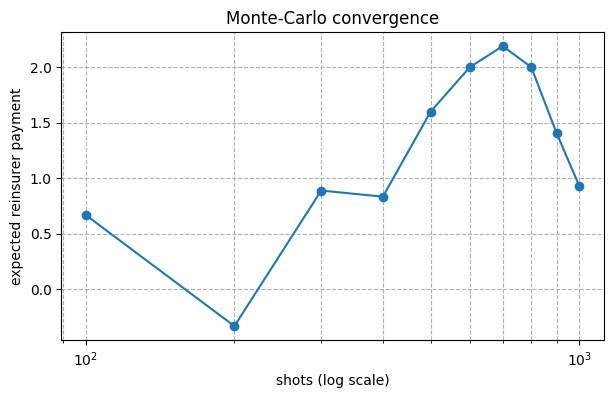

,shots,expected_payment
0,100.0,0.666667
1,200.0,-0.333333
2,300.0,0.888889
3,400.0,0.833333
4,500.0,1.600000
5,600.0,2.000000
6,700.0,2.190476
7,800.0,2.000000
8,900.0,1.407407
9,1000.0,0.933333


In [ ]:
df_conv = convergence_study(qc,
                            meas_idx=meas_idx,
                            c_param=c_param,
                            coins=coins,
                            shot_grid=np.linspace(100, 1_000, 10))
# Save for later comparison, if you like
df_conv.to_csv("mc_convergence.csv", index=False)
df_conv

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - (1 - coins) * (lnorm - deductible) - deductible
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - (1 - coins) * (lnorm_0_10 - deductible) - deductible
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_30800\2597867.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


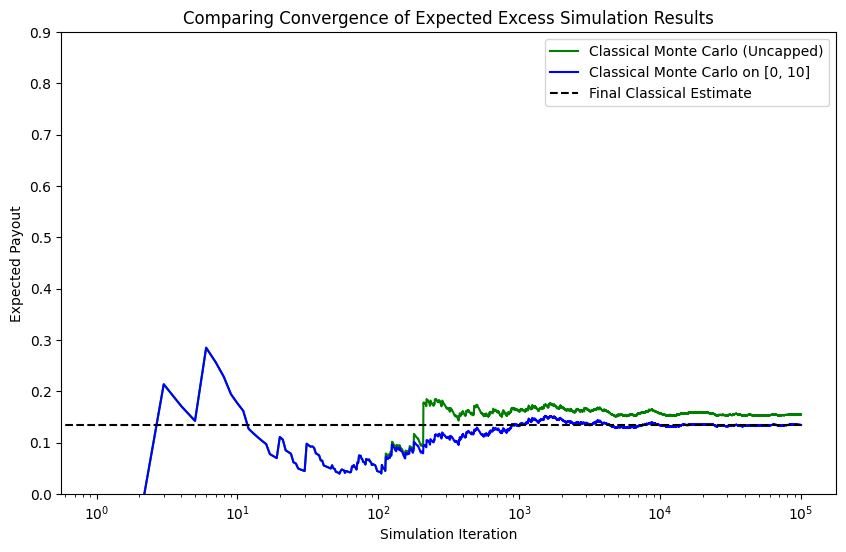

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Final Classical Estimate')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 0.9)
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [ ]:
cmc_running_mean_0_10[-1]

np.float64(0.13465517755970566)

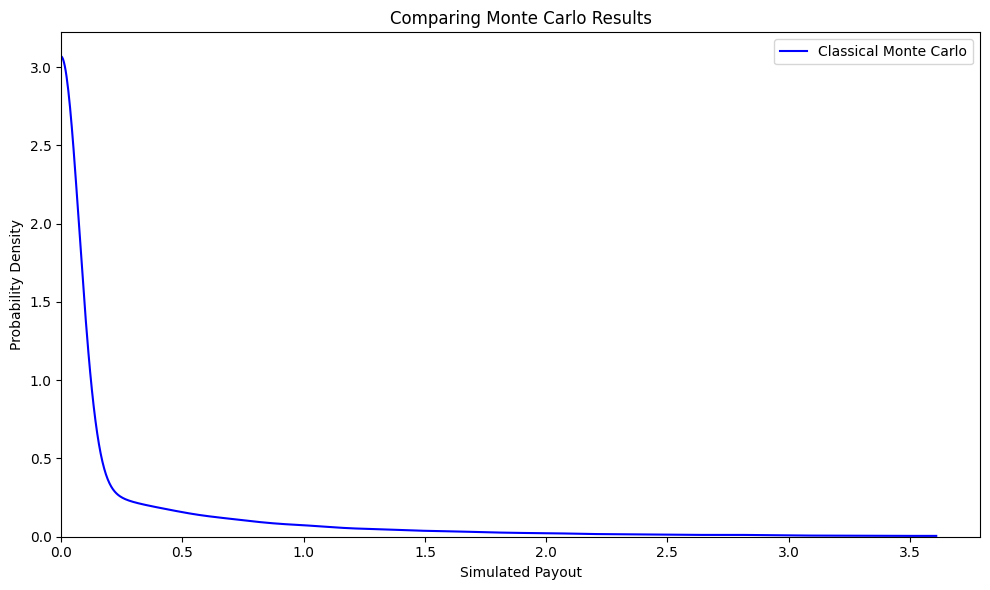

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()